# Patient Adherence in TPN Treatments

*Aviad Baram*

**Patient adherence** refers to the degree to which a patient correctly follows prescribed medical treatment regimens. In the context of **Total Parenteral Nutrition (TPN)**—a complex and critical therapy that delivers nutrients intravenously—adherence is essential for ensuring proper nutritional support, avoiding complications, and achieving treatment goals.

This notebook presents an analysis of TPN treatment data to assess **adherence behavior** across patients and treatment sessions. Adherence is evaluated by comparing **volume to be infused (VTBI)** with **actual volume infused (VI)** captured from infusion pumps. **Monthly mean VI/VTBI** is used as a metric to quantify adherence at a monthly level.

The goal of this analysis is to:
- Highlight deviation based on geographical location
- Provide presentable visualizations.

This notebook assumes that treatment data contained in the elastic index *'alon_test_treatments\*'* is correct.


## Setup

1. Import required modules
2. Import raw data as pandas DataFrame
   
Raw data is retrieved using the python code in `adherence_elasticdb_script.py`
**TODO**: add git repo


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
data_path = os.getenv('SHARED_DATA_PATH')  # env variable for data storage
raw_data_source_path = os.path.join(data_path, r'elastic_export\adherence_rawdf18062025.pkl')

In [3]:
df = pd.read_pickle(raw_data_source_path)
new_order = ['start_date', 'end_date', 'customer_name', 'pump_sn', 'vtbi_expected', 'vi', 'preset_program', 'country' ]
df_copy = df[new_order]
display(df_copy.head(5))

,start_date,end_date,customer_name,pump_sn,vtbi_expected,vi,preset_program,country
0,2020-01-01 00:01:39,2020-01-01 21:44:13,BASTIDE - Siège Social,300234382,2102.0,1862.0,New Infusion,France
1,2020-01-01 00:03:55,2020-01-02 00:03:34,Teva Medical LTD,300222461,2499.0,1463.0,Repeat Last Infusion,Israel
2,2020-01-01 00:09:09,2020-01-01 08:11:51,"Paragon Infusion Care, Inc. PLANO",300177472,1074.0,1074.0,Repeat Last Infusion,USA
3,2020-01-01 00:09:18,2020-01-01 09:11:17,University of Michigan Home Med,300159299,2500.0,2500.0,New Infusion,USA
4,2020-01-01 00:09:50,2020-01-01 12:13:11,University of Michigan HomeMed,300194562,3000.0,3000.0,New Infusion,USA


## Preprocessing



define static variables. These are variables that define a valid treatment.

In [4]:
# static vars


vtbi_tolerance = 1.0  # Tolerance for vtbi volume; consecutive treatments are considered identical if their volume difference is ≤ this value

treatment_range = [14, 365]  # the min and max number of days for a TPN treatment to be considered for adherence calculation

treatment_freq_threshold = 10  # the max allowed number of treatments per week for it to be considered

max_adherence_threshold = 1.1  # max allowed adherence ratio for a treatment week to be considered


remove infusions which are 
* duplicates (sanity check - max is the number of API scroll calls at data retrievals from elastic).
* have VTBI higher than 3500 ml
* end_date before start_date - sometime results from system time reset (e.g battery replacement in SAPPHIRE)


In [5]:
df = df_copy.copy()
df = df.sort_values(by='start_date')

raw_infusion_count = len(df.index)
print(f'Total raw infusions:\t{raw_infusion_count}')

dup_count = df.duplicated(subset=['start_date', 'pump_sn'], keep='first').sum()
df.drop_duplicates(subset=['start_date', 'pump_sn'], keep='first', inplace=True)
print(f'Duplicated infusions:\t{dup_count} ({100 * dup_count/raw_infusion_count:.2f}%)')
negative_duration_idx = df[df['end_date'] <= df['start_date']].index
neg_dur_count = len(negative_duration_idx)
print(f'Reversed duration infusions:\t{neg_dur_count} ({100 * neg_dur_count/raw_infusion_count:.2f}%)')

df = df[~df.index.isin(negative_duration_idx)]
infusions_lg_3500_idx = df[df['vtbi_expected']>3500].index
lg3500_count = len(infusions_lg_3500_idx)
print(f'VTBI > 3500 ml infusions:\t{lg3500_count} ({100 * lg3500_count/raw_infusion_count:.2f}%)')

df = df[~df.index.isin(infusions_lg_3500_idx)]
raw_infusion_count = len(df.index)
print(f'Total infusions:\t{len(df.index)} {100 * len(df.index)/raw_infusion_count:.2f}% recovery')


Total raw infusions:	1542296
Duplicated infusions:	115 (0.01%)
Reversed duration infusions:	497 (0.03%)
VTBI > 3500 ml infusions:	28996 (1.88%)
Total infusions:	1512688 100.00% recovery


## Exploratory Data Analysis

Group into patient treatments by:
1. Consecutive infusion treatments
2. Same pump serial number
3. `preset_program` set to `Repeat Last Infusion` AND/OR
4. `expected_vtbi` within `vtbi_tolerance` of previous `expected_vtbi`


In [6]:
patient_labels = pd.Series(index=df.index, dtype=int)
grouped = df.groupby('pump_sn')
patients = 0
# Define function to process each group
start_time = time.time()
for pump_sn, group in grouped:
    patients += 1
    group = group.sort_values(by='start_date')
    indices = group.index.tolist()
    # Start with the first row of the group
    patient_labels[indices[0]] = patients
    for i in range(1, len(indices)):
        prev_idx = indices[i - 1]
        curr_idx = indices[i]
        repeat_infusion = df.loc[curr_idx, 'preset_program'] == 'Repeat Last Infusion'
        same_vtbi = abs(df.loc[curr_idx, 'vtbi_expected'] - df.loc[prev_idx, 'vtbi_expected']) <= vtbi_tolerance # type: ignore
        # initialize new treatment if NOT repeated infusion and NOT the same vtbi (up to tolerance)
        if not repeat_infusion and not same_vtbi:
            patients += 1
        # assign patient value to current treatment
        patient_labels[curr_idx] = patients

# Assign to original DataFrame
df['patient'] = patient_labels
print(f'Total patients:\t{patients}')
end_time_patient = time.time()
print(f"Elapsed time for patient grouping: {end_time_patient - start_time:.2f} seconds")


Total patients:	204653
Elapsed time for patient grouping: 34.55 seconds


Calculate treatment duration

In [7]:
# calculate duration
start_time = time.time()
duration = df.groupby('patient').apply(
    lambda g: pd.Series({'duration': g['start_date'].iloc[-1] - g['start_date'].iloc[0],
                         'country': g['country'].mode().iloc[0]}), include_groups=False).reset_index()
duration['days'] = duration['duration'].dt.days
end_time = time.time()
print(f"Elapsed time for duration calculation: {end_time - start_time:.2f} seconds")

Elapsed time for duration calculation: 43.31 seconds


filter treatments episodes which are longer than 365 days or shorter than 14 days

In [8]:
over_365 = (duration['duration'] > pd.Timedelta(days=365)).sum()
print(f'Treatments with recorded duration > 365 days: {over_365}')
under_14 = (duration['duration'] < pd.Timedelta(days=14)).sum()
print(f'Treatments with recorded duration < 14 days: {under_14}')
all_treatments = len(df.index)
duration = duration[(duration['duration'] >= pd.Timedelta(days=treatment_range[0])) & (duration['duration'] <= pd.Timedelta(days=treatment_range[1]))]
print(f'Total Treatments:\t{len(duration.index)} ({100 * len(duration.index)/patients:.2f}% recovery)')
infusion_count = len(df.index)
df = df[df['patient'].isin(duration['patient'])]
print(f'Total infusions:\t{len(df.index)} ({100 * len(df.index)/infusion_count:.2f}% recovery)')

Treatments with recorded duration > 365 days: 3367
Treatments with recorded duration < 14 days: 177394
Total Treatments:	23892 (11.67% recovery)
Total infusions:	817335 (54.03% recovery)


**Filtering by duration results in the exclusion of ~90% of the identified treatments and ~45% of available infusions**

In [9]:
df_back = df.copy()

In [10]:
df = df.copy()  # suppress modifying a copy warning
# Get the first start_date per patient
df['treatment_start'] = df.groupby('patient')['start_date'].transform('min')
# Calculate week number since first_date
df['treatment_week'] = ((df['start_date'] - df['treatment_start']) // pd.Timedelta(days=7)).astype(int) + 1 # type: ignore
# Get calendar week for each interval start
df['interval_start'] = df['treatment_start'] + (df['treatment_week'] - 1) * pd.Timedelta(days=7)
df['month'] = df['interval_start'].dt.month
df['year'] = df['interval_start'].dt.year
df['day'] = 1

Group and aggregate by treatment week


In [11]:
weekly_summary = df.groupby(['patient', 'treatment_week']).agg(
    year = ('year', 'first'),
    country = ('country', lambda x: x.mode().iloc[0]),
    month = ('month', 'first'),
    max_vtbi=('vtbi_expected', 'max'),
    vi_sum=('vi', 'sum'),
    treatment_count=('start_date', 'count')
).reset_index()
wkly_patient_intvls = len(weekly_summary.index)  #  weekly/patient treatment intervals
print(f'Total weekly/patient treatment intervals:\t{wkly_patient_intvls}')

Total weekly/patient treatment intervals:	165830


Filter treatment weeks with an infusion count higher than the defined threshold (i.e `treatment_freq_threshold`)

In [12]:
high_frequency_weeks = (weekly_summary['treatment_count'] > treatment_freq_threshold).sum()
print(f'Treatment weeks with frequency density > {treatment_freq_threshold}: {high_frequency_weeks}')
weekly_summary = weekly_summary[weekly_summary['treatment_count'] <= treatment_freq_threshold]
print(f'Total weekly/patient treatment intervals:\t{len(weekly_summary.index)} ({100 * len(weekly_summary.index)/wkly_patient_intvls:.2f}% recovery)')
wkly_patient_intvls = len(weekly_summary.index)

Treatment weeks with frequency density > 10: 1408
Total weekly/patient treatment intervals:	164422 (99.15% recovery)


calculate patient adherence

In [13]:
patient_expected_weekly = weekly_summary.groupby('patient')['treatment_count'].transform(lambda x: x.max()).clip(upper=7)
weekly_summary['likely_vtbi'] = patient_expected_weekly
weekly_summary['likely_vtbi'] = weekly_summary['likely_vtbi'] * weekly_summary['max_vtbi']
weekly_summary['adherence_ratio'] = weekly_summary['vi_sum'] / weekly_summary['likely_vtbi']

In [14]:
# filter weekly adherence over 1.1
high_adherence_weeks = (weekly_summary['adherence_ratio'] > int(max_adherence_threshold)).sum()
print(f'Treatment weeks with adherence ratio density > {max_adherence_threshold}: {high_adherence_weeks}')
weekly_summary = weekly_summary[weekly_summary['adherence_ratio'] <= max_adherence_threshold]
print(f'Total weekly/patient treatment intervals:\t{len(weekly_summary.index)} ({100 * len(weekly_summary.index)/wkly_patient_intvls:.2f}% recovery)')
wkly_patient_intvls = len(weekly_summary.index)

Treatment weeks with adherence ratio density > 1.1: 9221
Total weekly/patient treatment intervals:	157746 (95.94% recovery)


In [15]:
# Create a combined 'country' category (show all) for visualizations
weekly_summary_all = weekly_summary.copy()
weekly_summary_all['country'] = 'All' 
weekly_summary = pd.concat([weekly_summary, weekly_summary_all], ignore_index=True)

patient_adherence = weekly_summary.groupby(['year', 'month', 'country']).agg(
    num_vals=('adherence_ratio', 'count'),
    mean_adherence=('adherence_ratio', 'mean')
)
patient_adherence.reset_index(inplace=True)
#  pd.to_datetime(patient_adherence[['calendar_year', 'calendar_month']].assign(day=1))
patient_adherence['month_year'] = pd.to_datetime(patient_adherence[['year', 'month']].assign(day=1))
patient_adherence['month_year_str'] = patient_adherence['month_year'].apply(
    lambda m: m.strftime('%Y-%m') if m.month == 1 else m.strftime('%m')
)

## Visualizations

In [16]:
selected_countries = ['USA', 'France']  #  ['USA', 'France', 'UK', 'Israel', 'Other']
dist_ylims = [0, 1]  # y limits for probability distribution function - overrides auto scaling
sns.set_theme(style="darkgrid")

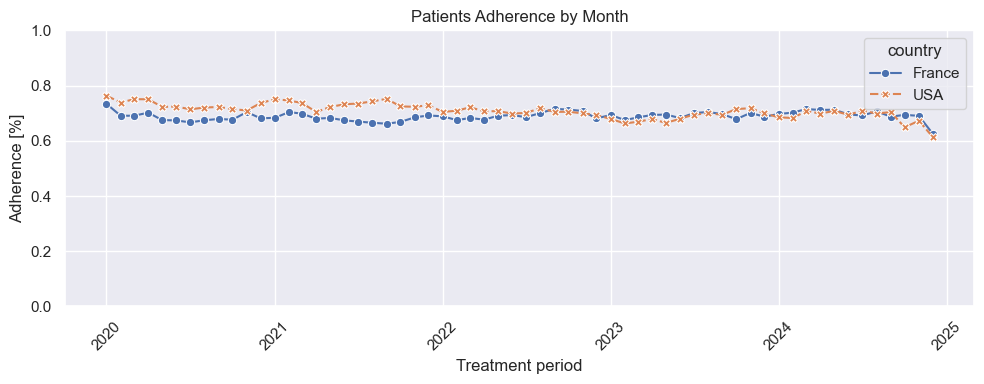

In [17]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=patient_adherence.loc[patient_adherence['country'].isin(selected_countries)],
              x='month_year', y='mean_adherence', hue='country',style='country', markers=True)
plt.title('Patients Adherence by Month')
plt.xlabel('Treatment period')
plt.ylabel('Adherence [%]')
plt.ylim(dist_ylims[0], dist_ylims[1])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
duration.columns

Index(['patient', 'duration', 'country', 'days'], dtype='object')

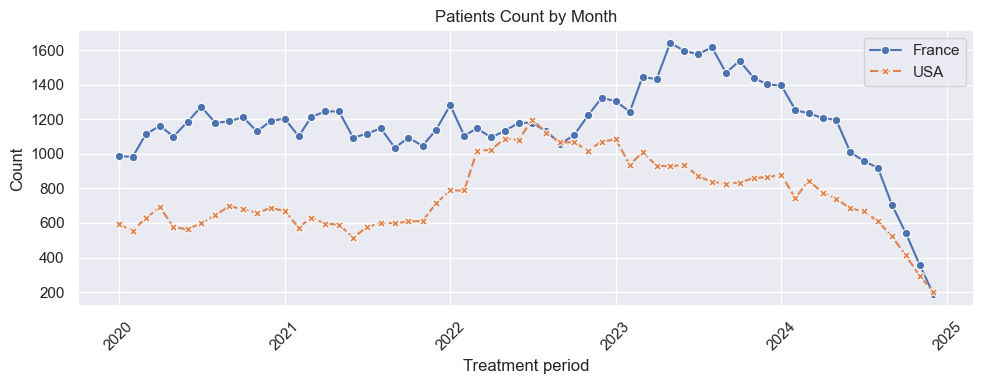

In [19]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=patient_adherence.loc[patient_adherence['country'].isin(selected_countries)],
              x='month_year', y='num_vals', hue='country',style='country', markers=True)
plt.legend()
plt.title('Patients Count by Month')
plt.xlabel('Treatment period')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

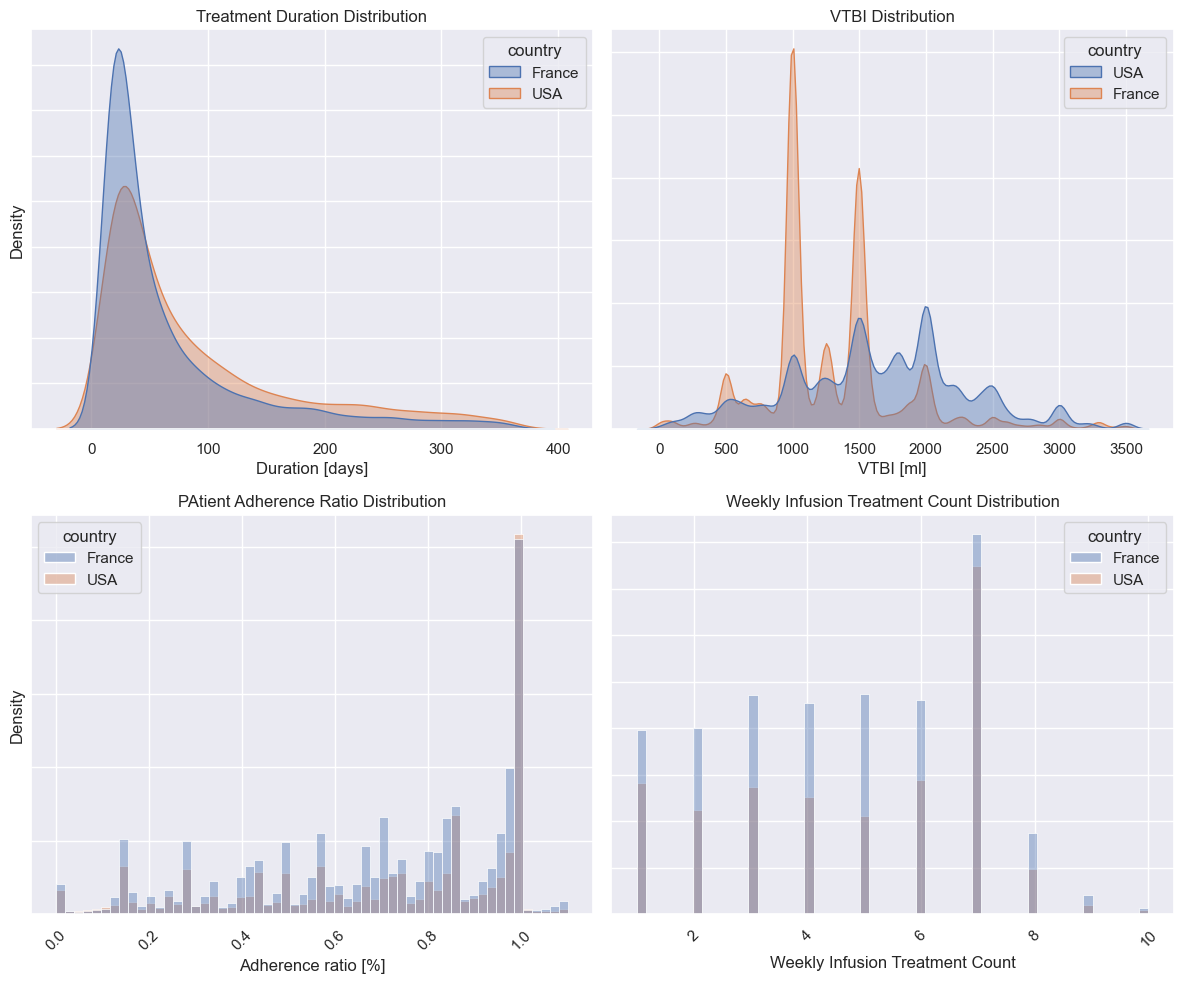

In [ ]:
# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns
# Flatten the axes array for easy indexing
axes = axes.flatten()
sns.kdeplot(data=duration[duration['country'].isin(selected_countries)], x='days', hue='country', common_norm=False, fill=True, alpha=0.4,
            ax=axes[0])
axes[0].tick_params(axis='y', left=False, labelleft=False)
axes[0].set_xlabel('Duration [days]')
axes[0].set_title('Treatment Duration Distribution')

sns.kdeplot(data=df[df['country'].isin(selected_countries)], x='vtbi_expected', hue='country', common_norm=False, fill=True, alpha=0.4,
            ax=axes[1])
axes[1].tick_params(axis='y', left=False, labelleft=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('VTBI [ml]')
axes[1].set_title('VTBI Distribution')

sns.histplot(data=weekly_summary[weekly_summary['country'].isin(selected_countries)], x='adherence_ratio', hue='country', stat='density',
             fill=True, alpha=0.4, ax=axes[2])
axes[2].tick_params(axis='y', left=False, labelleft=False)
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_xlabel('Adherence ratio [%]')
axes[2].set_title('Patient Adherence Ratio Distribution')

sns.histplot(data=weekly_summary[weekly_summary['country'].isin(selected_countries)], x='treatment_count', hue='country', stat='density',
             fill=True, alpha=0.4, ax=axes[3])
axes[3].tick_params(axis='y', left=False, labelleft=False)
axes[3].set_ylabel('')
axes[3].tick_params(axis='x', rotation=45)
axes[3].set_xlabel('Weekly Infusion Treatment Count')
axes[3].set_title('Weekly Infusion Treatment Count Distribution')

plt.tight_layout()
plt.show()
